У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from darts import TimeSeries
from darts.utils.statistics import check_seasonality, plot_acf
from darts.models import NaiveSeasonal, NaiveDrift, XGBModel, ExponentialSmoothing, ARIMA, AutoARIMA, Prophet, RNNModel
from darts.metrics import rmse, mape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

c:\Users\shyx8\Documents\ML_learning\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


In [2]:
raw_df = pd.read_csv("https://docs.google.com/spreadsheets/d/1FGX44uOd50z4x4ziGHmZzA43-XhauSAtU8GozUw1XGI/gviz/tq?tqx=out:csv&sheet=Sheet1")
raw_df['date'] = pd.to_datetime(raw_df['date'])
raw_df.set_index('date', inplace=True)
raw_df.sort_index(inplace=True)

display(raw_df.head(10))
display(raw_df.info())

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-01,7,12,26
2013-01-01,7,46,27
2013-01-01,8,12,54
2013-01-01,9,12,35
2013-01-01,10,12,41
2013-01-01,6,46,23
2013-01-01,1,13,37
2013-01-01,2,13,51


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


None

  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



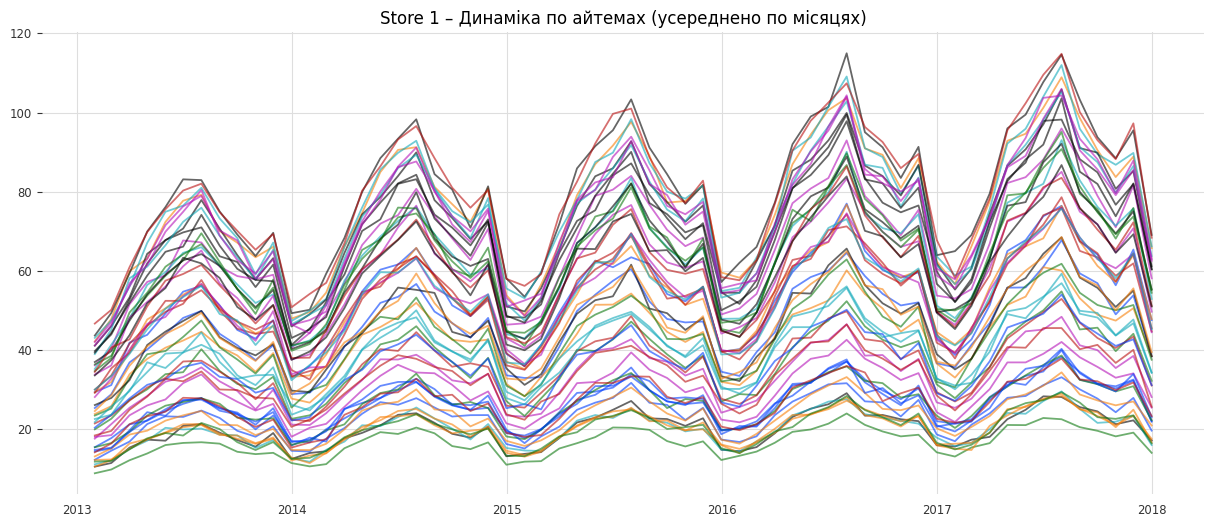

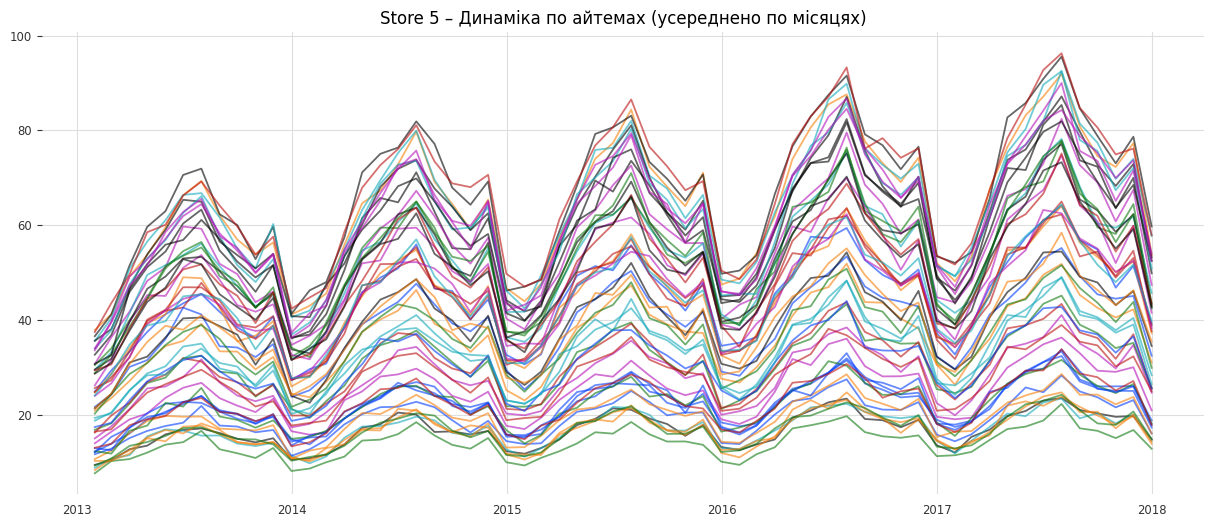

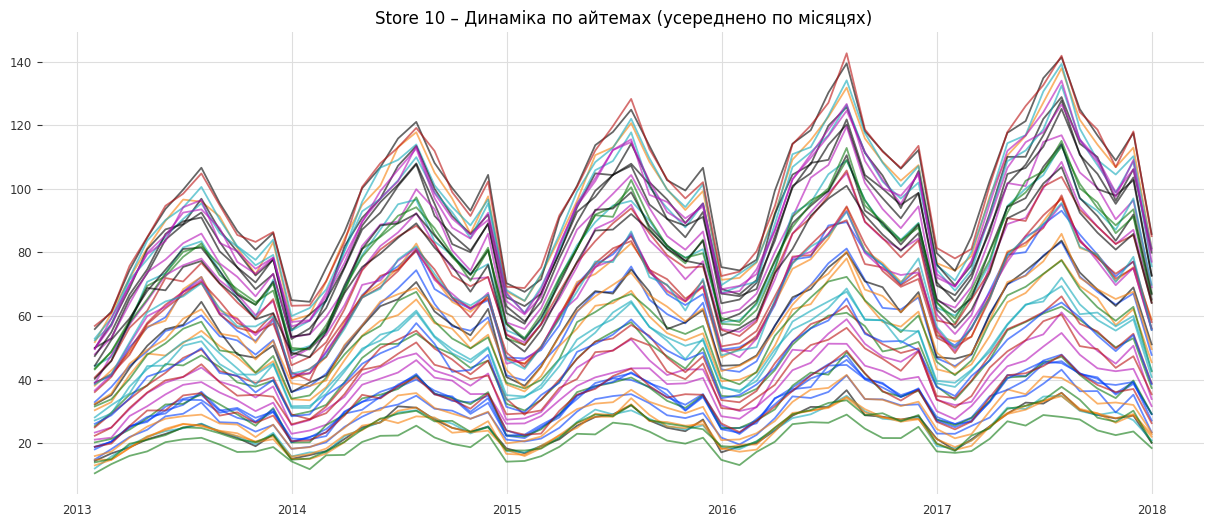

In [3]:
avg_sales = raw_df.groupby(["store", "item"]).resample("ME")["sales"].mean().reset_index()
store_ids = [1, 5, 10]

for store_id in store_ids:
    subset = avg_sales[avg_sales["store"]==store_id]
    plt.figure(figsize=(15,6))
    for item in subset["item"].unique():
        plt.plot(subset[subset["item"]==item]["date"], subset[subset["item"]==item]["sales"], alpha=0.6)
    plt.title(f"Store {store_id} – Динаміка по айтемах (усереднено по місяцях)")
    plt.show()



В загальному по трьом навмання вибраних магазинах спостерігається однакова тенденція продажів кожного айтема - усі товари підкоряються одній сезонності та тренду. Відмінність між ними в основному у рівні продажів, а не в патерні.

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

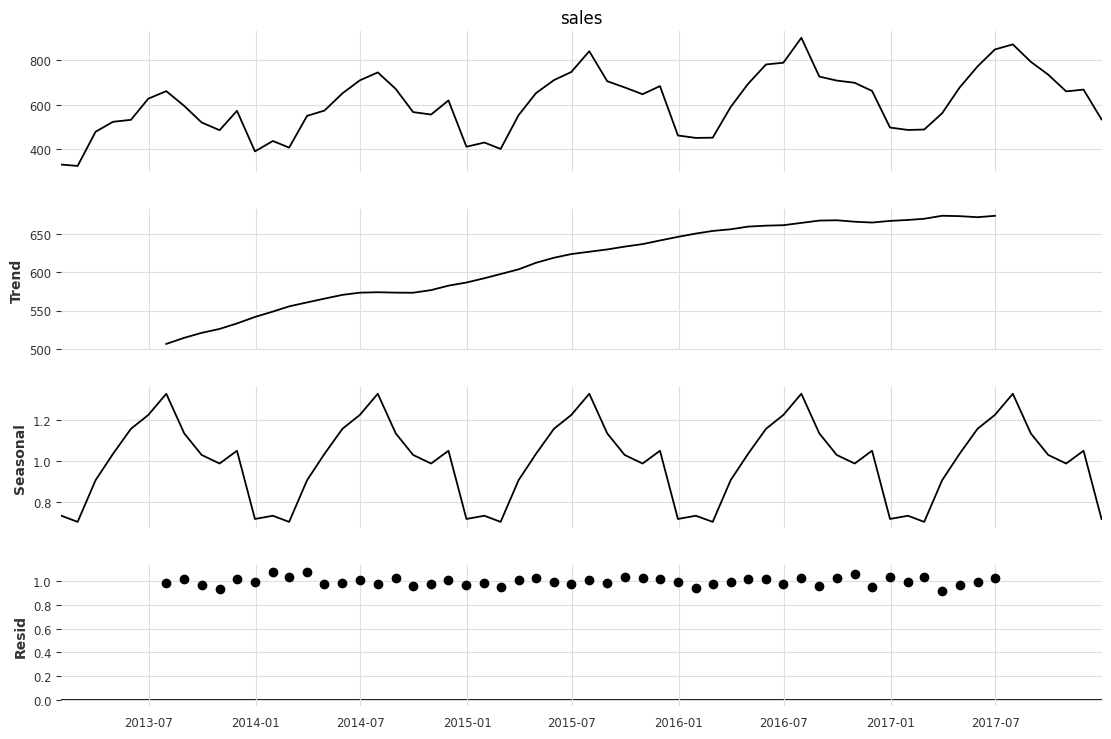

In [4]:
store_id = 1
item_id = 1
ts = raw_df[(raw_df["store"]==store_id) & (raw_df["item"]==item_id)]
# ts group by month end and sum sales
ts = ts.resample("ME").sum()

ts_sales = ts["sales"].resample("ME").sum()

decomp = seasonal_decompose(ts_sales, model="multiplicative", period=12)

fig = decomp.plot()
fig.set_size_inches(12, 8)
plt.show()

Ми отримали наступні візуалізації:
1. Sales – початковий ряд.

2. Trend – згладжений довгостроковий рух.

3. Seasonal – повторюваний сезонний патерн.

4. Residual – залишки (шум).

Часовий ряд має виражений зростаючий тренд, стабільну річну сезонність і відносно невеликий шум.
Це означає, що для прогнозування найкраще підходять моделі, які враховують тренд і сезонність

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [5]:
series = TimeSeries.from_series(ts['sales'], freq="M")
display(series)

<TimeSeries (date: 60, component: 1, sample: 1)> Size: 480B
array([[[328.]],

       [[322.]],

       [[477.]],

       [[522.]],

       [[531.]],

       [[627.]],

       [[661.]],

       [[594.]],

       [[519.]],

       [[484.]],

...

       [[561.]],

       [[677.]],

       [[773.]],

       [[850.]],

       [[873.]],

       [[794.]],

       [[736.]],

       [[660.]],

       [[668.]],

       [[533.]]])
Coordinates:
  * date       (date) datetime64[ns] 480B 2013-01-31 2013-02-28 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

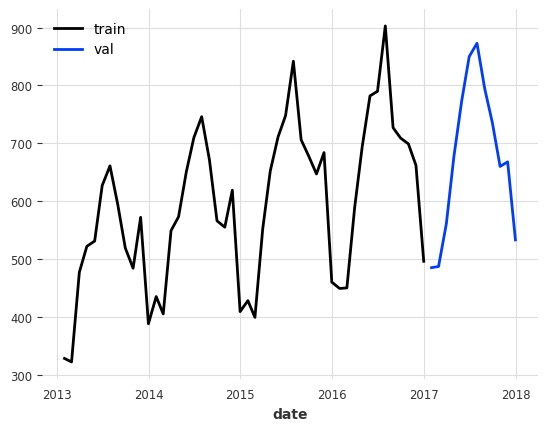

In [6]:
series1, series2 = series.split_after(pd.Timestamp("2017-01-01"))
series1.plot(label="train")
series2.plot(label="val")
plt.legend()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

<Figure size 1000x500 with 0 Axes>

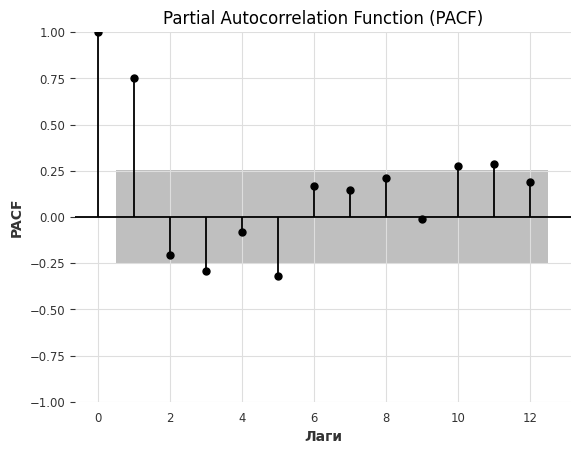

In [7]:
sales_series = series.to_dataframe()["sales"]

plt.figure(figsize=(10,5))
plot_pacf(sales_series, lags=12, method="ywm")
plt.title("Partial Autocorrelation Function (PACF)")
plt.xlabel("Лаги")
plt.ylabel("PACF")
plt.show()

Найважливіші лаги: 1, 2, 3, 4 і 12.

Це означає що У ARIMA/SARIMA можна розглядати модель із порядком AR(p) ≈ 4.

Для сезонності слід включити SAR(1) на періоді 12.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

Сезонність виявлена: True
Найбільш виражений сезонний період: 12 лагів


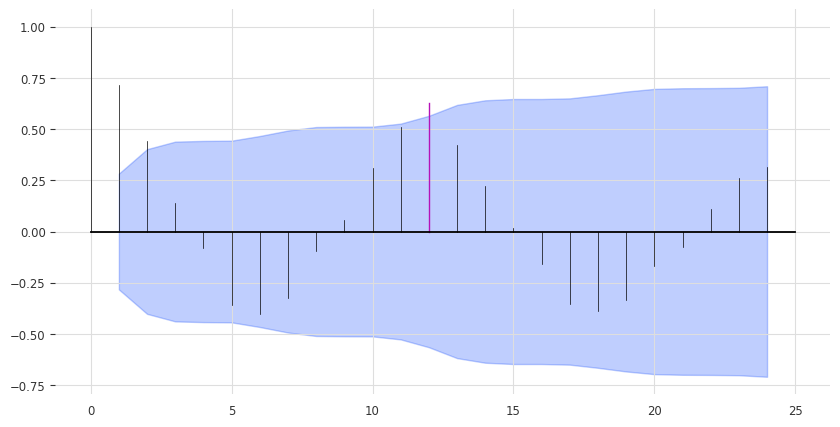

In [8]:
is_seasonal, period = check_seasonality(series1, max_lag=400)
print(f"Сезонність виявлена: {is_seasonal}")
if is_seasonal:
    print(f"Найбільш виражений сезонний період: {period} лагів")

plot_acf(series1, m=12, alpha=0.05, max_lag=24)

У тренувальному ряді є сезонність із періодом 12, що відповідає річному циклу (оскільки дані агреговані по місяцях).

Це означає, що:

 - продажі мають стабільний щорічний патерн,

 - при моделюванні треба використовувати сезонні моделі (SARIMA, ExponentialSmoothing з seasonal) з періодом сезонності = 12.

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

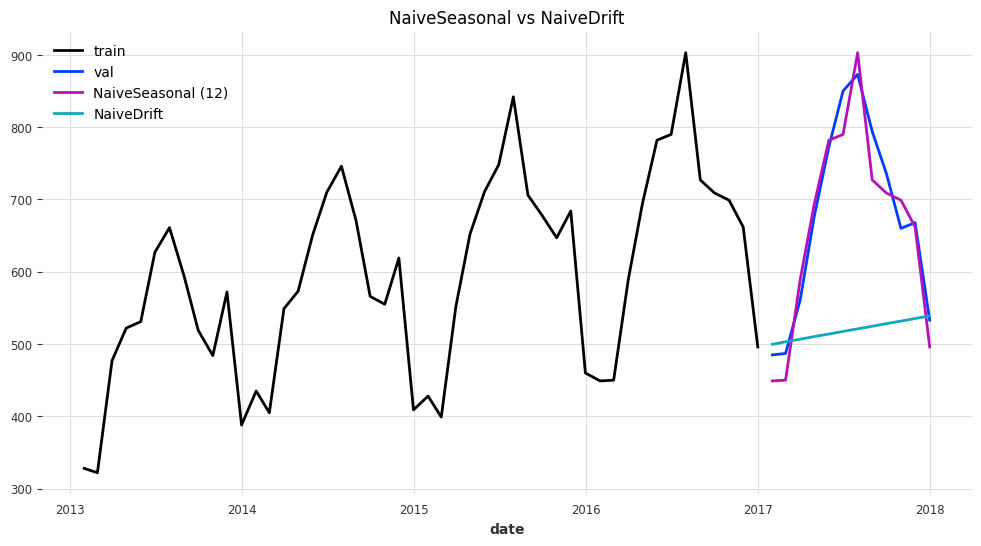

In [9]:
horizon = len(series2)

model_seasonal = NaiveSeasonal(K=12)
model_seasonal.fit(series1)
forecast_seasonal = model_seasonal.predict(horizon)

model_drift = NaiveDrift()
model_drift.fit(series1)
forecast_drift = model_drift.predict(horizon)

plt.figure(figsize=(12,6))
series1.plot(label="train")
series2.plot(label="val")
forecast_seasonal.plot(label="NaiveSeasonal (12)")
forecast_drift.plot(label="NaiveDrift")
plt.legend()
plt.title("NaiveSeasonal vs NaiveDrift")
plt.show()

NaiveSeasonal (12) - прогноз добре повторює справжній сезонний патерн, лінія майже накладається на валідаційні дані, тому модель дуже точна для свого класу.

NaiveDrift - прогноз ігнорує сезонність і продовжує лише загальний тренд.

NaiveSeasonal є значно точнішою за NaiveDrift, бо дані мають виражену сезонність з періодом 12 місяців.

NaiveDrift не підходить для даного ряду, адже він добре описує тільки випадки з монотонним трендом без яскраво виражених сезонних циклів.

Для покращення спробуємо скомбінувати дві моделі:

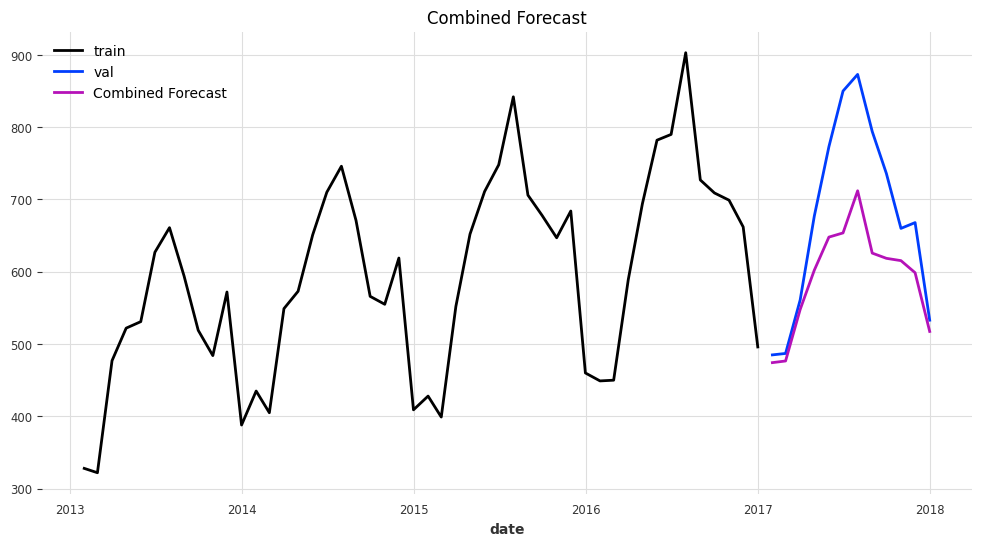

In [10]:
forecast_combined = (forecast_seasonal + forecast_drift) / 2

plt.figure(figsize=(12,6))
series1.plot(label="train")
series2.plot(label="val")
forecast_combined.plot(label="Combined Forecast")
plt.legend()
plt.title("Combined Forecast")
plt.show()

NaiveSeasonal (12) залишається найкращою наївною моделлю для цього ряду, бо дані мають чітку сезонність.

NaiveDrift додає трендовий компонент, але в даних тренд слабший за сезонність, тому комбінація погіршує прогноз.

Для наївних методів оптимальний вибір — чистий NaiveSeasonal з K=12.

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [11]:
horizon = len(series2)

model_seasonal = NaiveSeasonal(K=12)
model_seasonal.fit(series1)
forecast_seasonal = model_seasonal.predict(horizon)

val_mape = mape(series2, forecast_seasonal)
print("MAPE на валідації (NaiveSeasonal, K=12):", val_mape)

MAPE на валідації (NaiveSeasonal, K=12): 5.003152095317054


Базова наївна модель з MAPE ≈ 5% показує хорошу якість.

Всі подальші моделі треба порівнювати саме з цим значенням і якщо вони не кращі, то складніші моделі не мають сенсу.

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

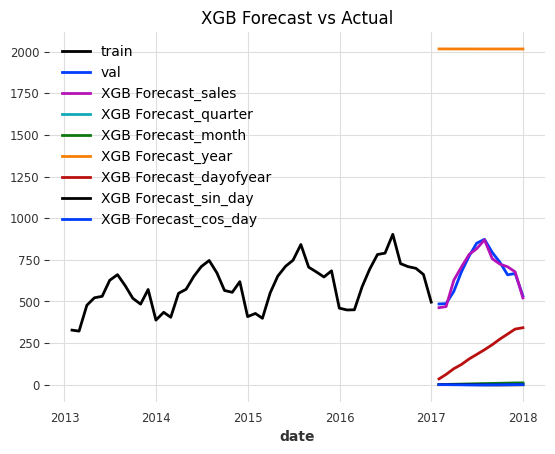

MAPE на валідації (XGB): 8.460191508988789


In [12]:
def enrich_with_datetime_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    idx = df.index
    df["quarter"]  = idx.quarter
    df["month"]    = idx.month
    df["year"]     = idx.year
    df["dayofyear"]= idx.dayofyear
    df["sin_day"]  = np.sin(2*np.pi*idx.dayofyear/365.25)
    df["cos_day"]  = np.cos(2*np.pi*idx.dayofyear/365.25)
    return df

train_df = enrich_with_datetime_features(series1.to_dataframe())
val_df   = enrich_with_datetime_features(series2.to_dataframe())

train = TimeSeries.from_dataframe(train_df)
val = TimeSeries.from_dataframe(val_df)

cov_scaler = Scaler()

train_s= cov_scaler.fit_transform(train)
val_s  = cov_scaler.transform(val)

model_xgb = XGBModel(
    lags=12,
    output_chunk_length=1,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    subsample=0.8,
    colsample_bytree=0.8
)

model_xgb.fit(train_s)
pred_xgb_s = model_xgb.predict(len(series2), series=train_s)
cov_scaler.inverse_transform(pred_xgb_s)

forecast = cov_scaler.inverse_transform(pred_xgb_s)

series1.plot(label="train")
series2.plot(label="val")
forecast.plot(label="XGB Forecast")
plt.legend()
plt.title("XGB Forecast vs Actual")
plt.show()

val_mape_xgb = mape(val, forecast)
print("MAPE на валідації (XGB):", val_mape_xgb)



XGBModel з календарними ознаками дає відносно непоганий прогноз (MAPE < 10%). Але вона поступається простій сезонній наївній моделі (5%). Модель добре відловлює тренд, частково враховує сезонність, але не відтворює амплітуду коливань. Модель краще, ніж NaiveDrift, але гірше, ніж NaiveSeasonal. Це означає, що сезонність — головний чинник у даних, і XGB поки що не використовує її достатньо ефективно.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

MAPE на валідації (ExponentialSmoothing): 5.521171918928451


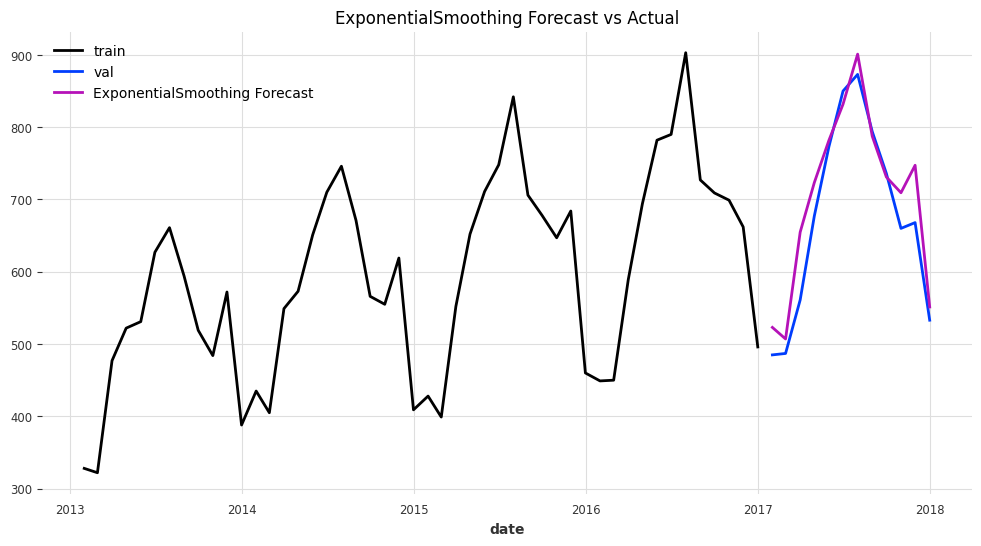

In [13]:
model_es = ExponentialSmoothing()
model_es.fit(series1)

forecast_es = model_es.predict(len(series2))
val_mape_es = mape(series2, forecast_es)
print("MAPE на валідації (ExponentialSmoothing):", val_mape_es)

plt.figure(figsize=(12,6))
series1.plot(label="train")
series2.plot(label="val")
forecast_es.plot(label="ExponentialSmoothing Forecast")
plt.legend()
plt.title("ExponentialSmoothing Forecast vs Actual")
plt.show()

ExponentialSmoothing підтвердила свою ефективність для цього ряду — вона враховує сезонність і тренд краще, ніж XGB. За якістю (MAPE ≈ 5.5%) вона на рівні з найкращим наївним бенчмарком (NaiveSeasonal).

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

c:\Users\shyx8\Documents\ML_learning\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


MAPE на валідації (ARIMA): 4.373172816322261


c:\Users\shyx8\Documents\ML_learning\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


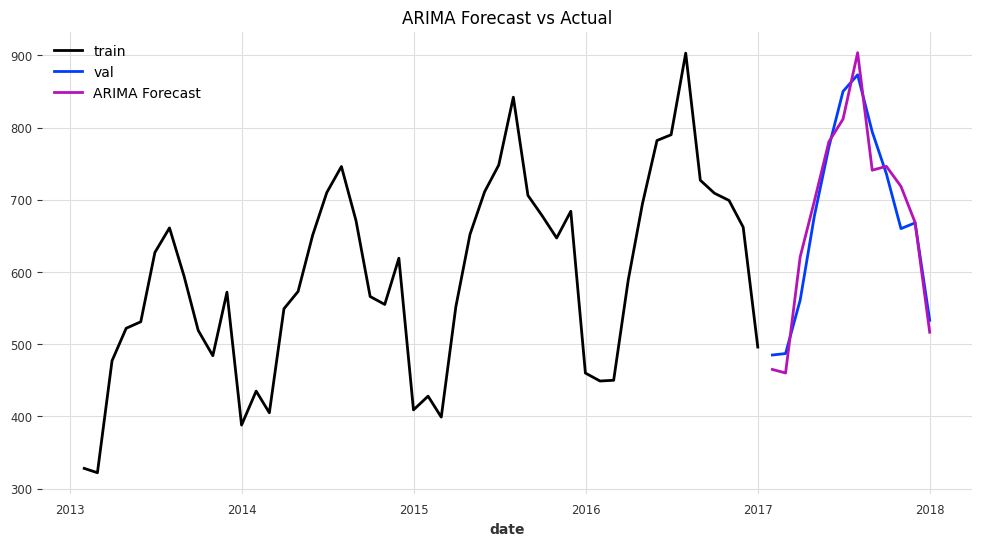

In [14]:
model_arima = ARIMA(p=12, d=1, q=1)
model_arima.fit(series1)

forecast_arima = model_arima.predict(len(series2))
val_mape_arima = mape(series2, forecast_arima)
print("MAPE на валідації (ARIMA):", val_mape_arima)

plt.figure(figsize=(12,6))
series1.plot(label="train")
series2.plot(label="val")
forecast_arima.plot(label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()

MAPE становить 4.37% і це найкращий результат серед усіх моделей дотепер (NaiveSeasonal ≈ 5.0%, ExponentialSmoothing ≈ 5.52%, XGB ≈ 8.46%, NaiveDrift ≈ 21%).

На графіку прогноз дуже близько повторює валідаційні значення, у піках невеликі похибки, але загальна форма сезонного циклу і тренду відтворені добре.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

MAPE на валідації (AutoARIMA): 10.60162851329355


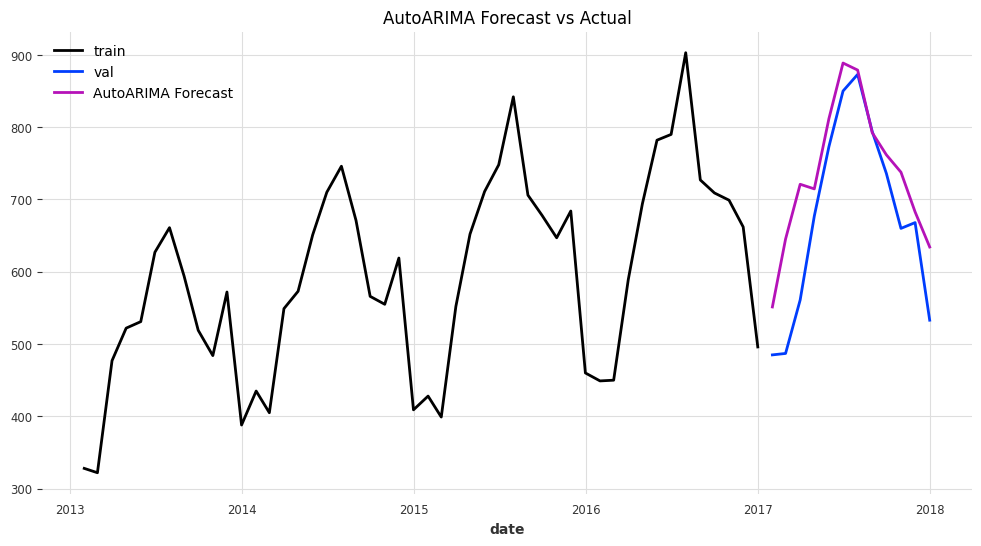

In [15]:
model_auto = AutoARIMA(
    start_p=5, start_q=1,
    max_p=12
)

model_auto.fit(series1)
forecast_auto = model_auto.predict(len(series2))
val_mape_auto = mape(series2, forecast_auto)
print("MAPE на валідації (AutoARIMA):", val_mape_auto)

plt.figure(figsize=(12,6))
series1.plot(label="train")
series2.plot(label="val")
forecast_auto.plot(label="AutoARIMA Forecast")
plt.legend()
plt.title("AutoARIMA Forecast vs Actual")
plt.show()


MAPE на валідації ≈ 10.6% і це значно гірше, ніж у попередніх моделей.

На графіку видно, що AutoARIMA непогано відловила форму тренду, але помилилася в амплітуді та фазі сезонних коливань і прогноз вийшов «зсунутим» і більш грубим.

14. Натренуйте модель Prophet та зробіть висновок про її якість.

21:10:08 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE на валідації (Prophet): 8.502821199909821


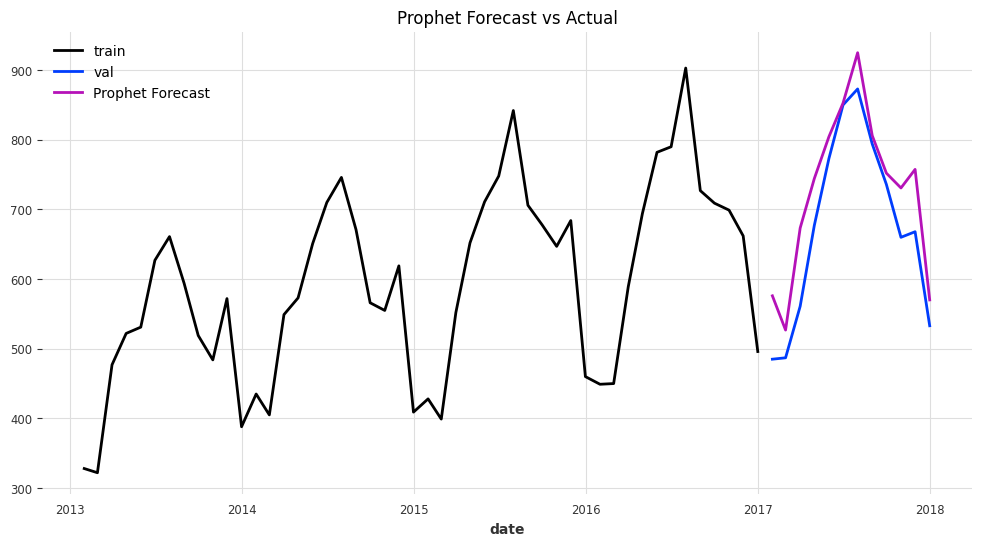

In [16]:
model_prophet = Prophet()

model_prophet.fit(series1)
forecast_prophet = model_prophet.predict(len(series2))
val_mape_prophet = mape(series2, forecast_prophet)
print("MAPE на валідації (Prophet):", val_mape_prophet)

plt.figure(figsize=(12,6))
series1.plot(label="train")
series2.plot(label="val")
forecast_prophet.plot(label="Prophet Forecast")
plt.legend()
plt.title("Prophet Forecast vs Actual")
plt.show()

MAPE на валідації ≈ 8.50%. Це гірше, ніж у ARIMA (4.37%), ExponentialSmoothing (5.52%) і NaiveSeasonal (~5%). Якість на рівні з XGB (~8.46%).

На графіку видно, що Prophet відтворює тренд і сезонність, але сильніше згладжує піки — прогноз стає більш «усередненим».

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
c:\Users\shyx8\Documents\ML_learning\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
----------

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE на валідації (RNN): 95.83638890906423


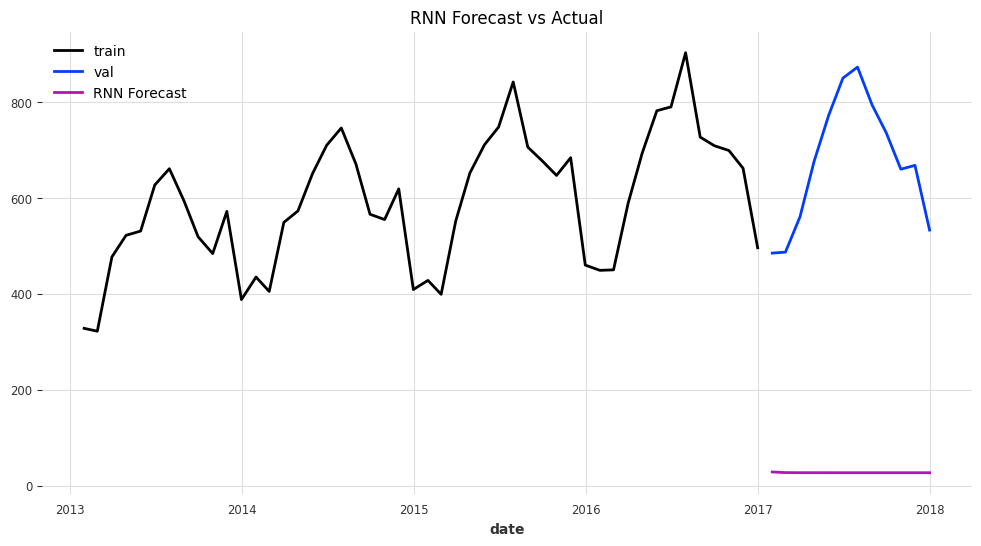

In [17]:
model_rnn = RNNModel(
    model="LSTM",
    dropout=0.2,
    batch_size=8,
    hidden_dim=64,
    n_epochs=400,
    optimizer_kwargs={"lr": 1e-3},
    model_name="rnn_model",
    random_state=42,
    log_tensorboard=True,
    force_reset=True,
    input_chunk_length=24,
    output_chunk_length=12
)

model_rnn.fit(series1)
forecast_rnn = model_rnn.predict(len(series2))
val_mape_rnn = mape(series2, forecast_rnn)
print("MAPE на валідації (RNN):", val_mape_rnn)

plt.figure(figsize=(12,6))
series1.plot(label="train")
series2.plot(label="val")
forecast_rnn.plot(label="RNN Forecast")
plt.legend()
plt.title("RNN Forecast vs Actual")
plt.show()

Прогноз рожевою лінією — майже постійна ~20, а MAPE ≈ 96% i це типово для невдалого навчання RNN: модель «скотилась» до константи (усередненого/стартового значення)

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

historical forecasts:   0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\shyx8\Documents\ML_learning\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\shyx8\Documents\ML_learning\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\shyx8\Documents\ML_learning\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\shyx8\Documents\ML_learning\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:

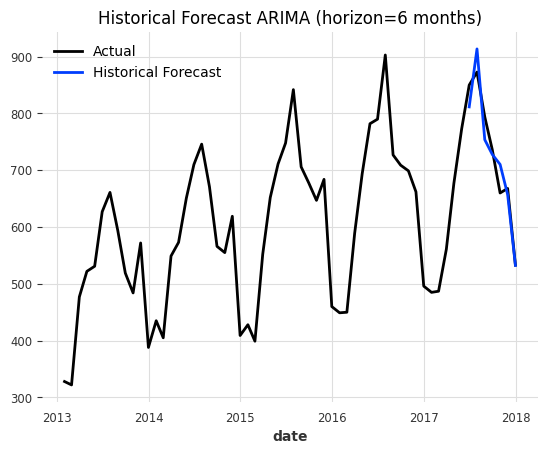

MAPE історичного прогнозу: 3.5267064136144777


In [48]:
hfc_parametrs = {
    "series": series,
    "start": pd.Timestamp("2017-01-01"),
    "forecast_horizon": 6,
    "verbose": True
}

history_forecast = model_arima.historical_forecasts(last_points_only=True, **hfc_parametrs)


series.plot(label="Actual")
history_forecast.plot(label="Historical Forecast")
plt.title("Historical Forecast ARIMA (horizon=6 months)")
plt.legend()
plt.show()

print("MAPE історичного прогнозу:", mape(series, history_forecast))

MAPE історичного прогнозу 3.52%. Це краще, ніж у ARIMA з горизонтом 1 місяць (4.37%), ніж ExponentialSmoothing (5.52%) і NaiveSeasonal (~5%).


Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Для задачі прогнозування 50 айтемів у 10 магазинах я б використала одну глобальну модель (наприклад, XGBModel або N-BEATS/BlockRNN у darts), яка вчиться на всіх рядах одночасно з календарними та ідентифікаційними ознаками.
Це дозволить отримати кращу узагальненість, менший час тренування і точніші прогнози, ніж якщо будувати 500 незалежних моделей.